In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
import joblib

In [2]:
data = pd.read_parquet('train_dataset_hackaton2023_train.gzip')
LA = LabelEncoder()

In [3]:
# Загрузите сохраненную модель из файла
kmean = joblib.load('kmeans_model.pkl')

In [4]:
def preproces(df):
    data = df.copy()
    data = data.drop(['group_name', 'dish_name'], axis=1)
    cost = data.groupby(['customer_id', 'startdatetime'], as_index=False).agg({'revenue':'sum'})
    data = data.drop('revenue', axis=1)
    data = data.merge(cost, on=['customer_id', 'startdatetime'], how='left')
    cost = data.groupby(['customer_id'], as_index=False).agg({'revenue':'sum'})
    data = data.rename(columns={'revenue':'check'})
    data = data.merge(cost, on=['customer_id'], how='left')
    data = data.rename(columns={'revenue':'sum'})
    data['dw'] = data.startdatetime.dt.day_of_week
    data['month'] = data.startdatetime.dt.month
    data['dy'] = data.startdatetime.dt.day_of_year
    data['hour'] = data.startdatetime.dt.hour
    data = data.sort_values(by='startdatetime', ascending=False)
    data = data.groupby('customer_id').head(1)
    data = data.drop('startdatetime', axis=1)
    data.format_name = LA.fit_transform(data.format_name)
    return data

In [5]:
data= preproces(data)
target = data.buy_post
data = data.drop(['date_diff_post', 'buy_post'], axis=1)

In [6]:
print(classification_report(target, kmean.labels_))
f1_score(target, kmean.labels_, average='binary')

              precision    recall  f1-score   support

           0       0.30      0.66      0.41    140905
           1       0.75      0.40      0.52    359095

    accuracy                           0.47    500000
   macro avg       0.53      0.53      0.47    500000
weighted avg       0.62      0.47      0.49    500000



0.5229107773370735

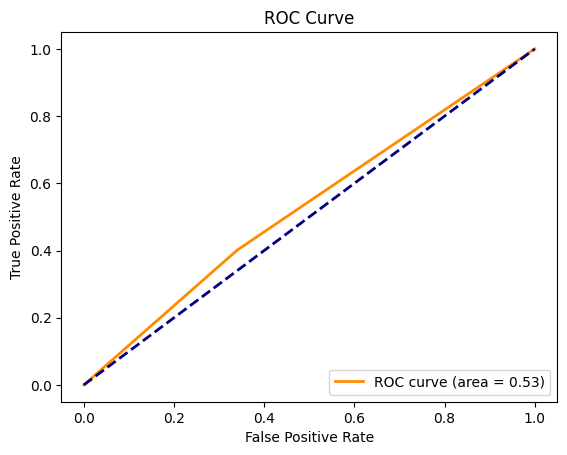

In [7]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(target, kmean.labels_)
roc_auc = auc(fpr, tpr)

# Построение графика ROC-AUC
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [8]:
test = pd.read_parquet('test_dataset_hackaton2023_test.gzip')

In [9]:
test = preproces(test)

In [10]:
result = kmean.predict(test)

In [11]:
sub = pd.read_csv('submission.csv', sep=';')

In [12]:
sub.buy_post = result

In [13]:
sub.to_csv('cluste.csv', sep=';', index=False)